In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [316]:
df = pd.read_csv('data.csv')
df['correct'] = (df.true == df.pred)
df['(true=1,pred=1)'] = (df.true == 1) &  (df.pred == 1)
df['(true=1,pred=0)'] = (df.true == 1) &  (df.pred == 0)
df['(true=0,pred=1)'] = (df.true == 0) &  (df.pred == 1)
df['(true=0,pred=0)'] = (df.true == 0) &  (df.pred == 0)
df[:6]

,id,expt_id,duration,true,pred,age,gender,filename,correct,"(true=1,pred=1)","(true=1,pred=0)","(true=0,pred=1)","(true=0,pred=0)"
0,1,1,5000,1,1,20,male,real/real-45.jpg,True,True,False,False,False
1,2,1,5000,0,0,20,male,gan/gan-7.jpg,True,False,False,False,True
2,3,1,5000,1,0,20,male,real/real-25.jpg,False,False,True,False,False
3,4,1,5000,0,0,20,male,gan/gan-31.jpg,True,False,False,False,True
4,5,1,5000,0,0,20,male,gan/gan-11.jpg,True,False,False,False,True
5,6,1,5000,1,1,20,male,real/real-5.jpg,True,True,False,False,False


In [317]:
# df = df[:6516] #No-ML
# df = df[6516:] #Yes-ML
print (df.shape)

(156252, 13)


In [318]:
df.groupby(["expt_id", "duration"]).true.mean()

expt_id  duration
1        250         0.498659
         500         0.501036
         1000        0.503050
         2000        0.501083
         5000        0.497342
2        250         0.498944
         500         0.504662
         1000        0.495320
         2000        0.504699
         5000        0.497485
Name: true, dtype: float64

In [319]:
dur1 = 5000
dur2 = 1000
id1 = 1
id2 = 1
exp1_data = df[(df.expt_id==id1) & (df.duration==dur1)].correct
exp2_data = df[(df.expt_id==id2) & (df.duration==dur2)].correct

print (exp1_data.mean())
print (exp2_data.mean())


from scipy.stats import ttest_ind

print (ttest_ind(exp1_data, exp2_data))

0.6627616984970794
0.6310388227321134
Ttest_indResult(statistic=7.383317595370402, pvalue=1.5673407593104228e-13)


In [320]:
indiv_df = df.groupby(by=lambda x: x//6, axis=0).agg({
    'expt_id': 'max',
    'duration': 'max',
    'age': 'max',
    'gender': 'max',
    'id': 'nunique',
    'true': 'sum',
    'correct': 'mean',
    '(true=1,pred=1)': 'sum',
    '(true=1,pred=0)': 'sum',
    '(true=0,pred=1)': 'sum',
    '(true=0,pred=0)': 'sum',
})


indiv_df['accuracy'] = indiv_df.correct
indiv_df['(pred=1|true=1)'] = indiv_df['(true=1,pred=1)'] / 3.
indiv_df['(pred=0|true=1)'] = indiv_df['(true=1,pred=0)'] / 3.
indiv_df['(pred=1|true=0)'] = indiv_df['(true=0,pred=1)'] / 3.
indiv_df['(pred=0|true=0)'] = indiv_df['(true=0,pred=0)'] / 3.

indiv_df = indiv_df[[
    'expt_id',
    'duration',
    'age',
    'gender',
    'id',
    'true',
    'accuracy',
    '(pred=1|true=1)',
    '(pred=0|true=1)',
    '(pred=1|true=0)',
    '(pred=0|true=0)',
]]

indiv_df.head()

,expt_id,duration,age,gender,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0)
0,1,5000,20,male,6,3,0.833333,0.666667,0.333333,0.000000,1.000000
1,1,2000,20,male,6,3,0.833333,1.000000,0.000000,0.333333,0.666667
2,1,1000,20,male,6,3,0.500000,1.000000,0.000000,1.000000,0.000000
3,1,500,20,male,6,3,0.500000,0.666667,0.333333,0.666667,0.333333
4,1,250,20,male,6,3,0.333333,0.666667,0.333333,1.000000,0.000000


In [327]:
def conf_interval(N, p_success):
    return (1.96/N)*np.sqrt(p_success*(1-p_success)*N) #90% conf interval


def get_results(df, columns):
    results = df.groupby(columns).agg({
        'id': 'sum',
        'true': 'sum',
        'accuracy': 'mean',
        '(pred=1|true=1)': 'mean',
        '(pred=0|true=1)':'mean',
        '(pred=1|true=0)': 'mean',
        '(pred=0|true=0)': 'mean',
    }).reset_index()
    
    results['accuracy_conf'] = conf_interval(results.id, results.accuracy)
    results['(pred=1|true=1)_conf'] = conf_interval(results.true, results['(pred=1|true=1)'])
    results['(pred=0|true=1)_conf'] = conf_interval(results.true, results['(pred=0|true=1)'])
    results['(pred=1|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=1|true=0)'])
    results['(pred=0|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=0|true=0)'])

    return results

indiv_results = get_results(indiv_df, ['expt_id', 'duration'])
indiv_gender_results = get_results(indiv_df, ['expt_id', 'duration', 'gender'])

indiv_results

,expt_id,duration,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0),accuracy_conf,(pred=1|true=1)_conf,(pred=0|true=1)_conf,(pred=1|true=0)_conf,(pred=0|true=0)_conf
0,1,250,17892,8922,0.543874,0.605187,0.392131,0.520121,0.482562,0.007298,0.010143,0.010131,0.010339,0.010341
1,1,500,19314,9677,0.597132,0.591074,0.410997,0.394740,0.603189,0.006917,0.009796,0.009803,0.009759,0.009768
2,1,1000,20658,10392,0.631039,0.608578,0.397522,0.340401,0.653500,0.006580,0.009384,0.009409,0.009166,0.009205
3,1,2000,22170,11109,0.665539,0.640595,0.361570,0.307352,0.690483,0.006211,0.008923,0.008935,0.008599,0.008615
4,1,5000,30474,15156,0.662762,0.637461,0.357223,0.317254,0.688062,0.005308,0.007654,0.007629,0.007370,0.007337
5,2,250,8520,4251,0.528169,0.558216,0.439671,0.503991,0.498122,0.010600,0.014929,0.014921,0.014999,0.014999
6,2,500,8580,4330,0.580886,0.553846,0.455478,0.382751,0.607925,0.010441,0.014806,0.014834,0.014613,0.014678
7,2,1000,8760,4339,0.619521,0.570320,0.420320,0.340639,0.668721,0.010167,0.014730,0.014687,0.013970,0.013874
8,2,2000,9150,4618,0.662732,0.636284,0.373115,0.301421,0.689180,0.009687,0.013875,0.013949,0.013360,0.013475
9,2,5000,10734,5340,0.684740,0.662381,0.332588,0.297932,0.707099,0.008790,0.012684,0.012637,0.012205,0.012145


1) Overall, what is the distribution of real vs. fake responses per duration
2) What are the component of the error (FPR, FNR)
3) When eyes are removed, do people think images are fake more often

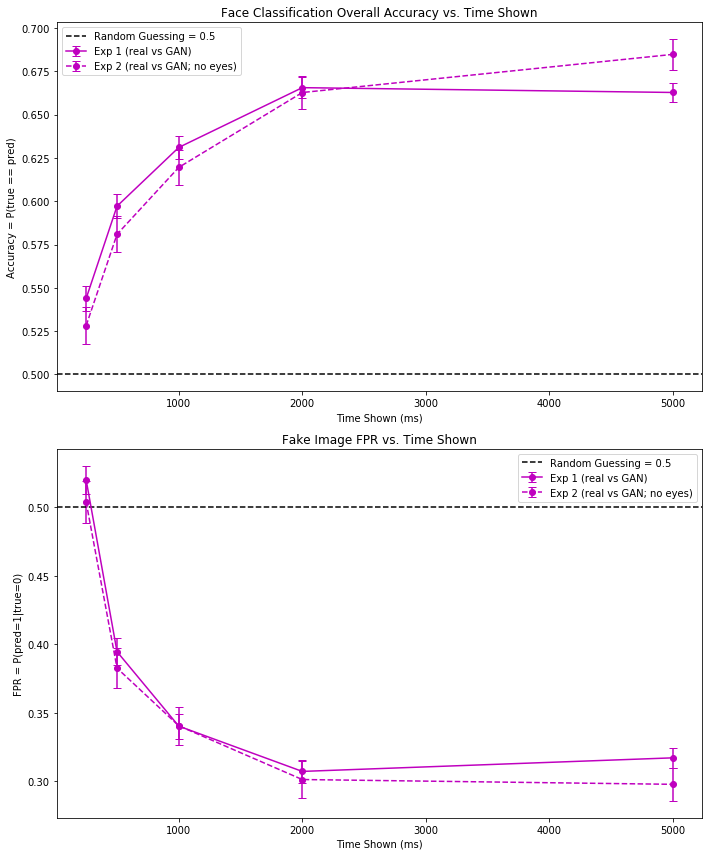

In [328]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)
ax1.set_title("Face Classification Overall Accuracy vs. Time Shown")
ax1.set_xlabel("Time Shown (ms)")
ax1.set_ylabel("Accuracy = P(true == pred)")
ax2 = fig.add_subplot(212)
ax2.set_title("Fake Image FPR vs. Time Shown")
ax2.set_xlabel("Time Shown (ms)")
ax2.set_ylabel("FPR = P(pred=1|true=0)")

id_map = {
    1:("Exp 1 (real vs GAN)", "m", "-"), 
    2:("Exp 2 (real vs GAN; no eyes)", "m", "--")
}

for expt_id, (label, color, linestyle)  in id_map.items():
    exp_data = indiv_results[indiv_results.expt_id == expt_id]
    ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)

#     exp_data = results[results.expt_id == expt_id]
#     ax1.plot(exp_data.duration, exp_data.accuracy, color=color, linestyle=linestyle, marker='o', label=label)
#     ax2.plot(exp_data.duration, exp_data['(pred=1|true=0)'], color=color, linestyle=linestyle, marker='o', label=label)
    
#     print (exp_data.accuracy)

ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")

ax1.legend(loc=0)
ax2.legend(loc=0)

plt.tight_layout()
plt.show()

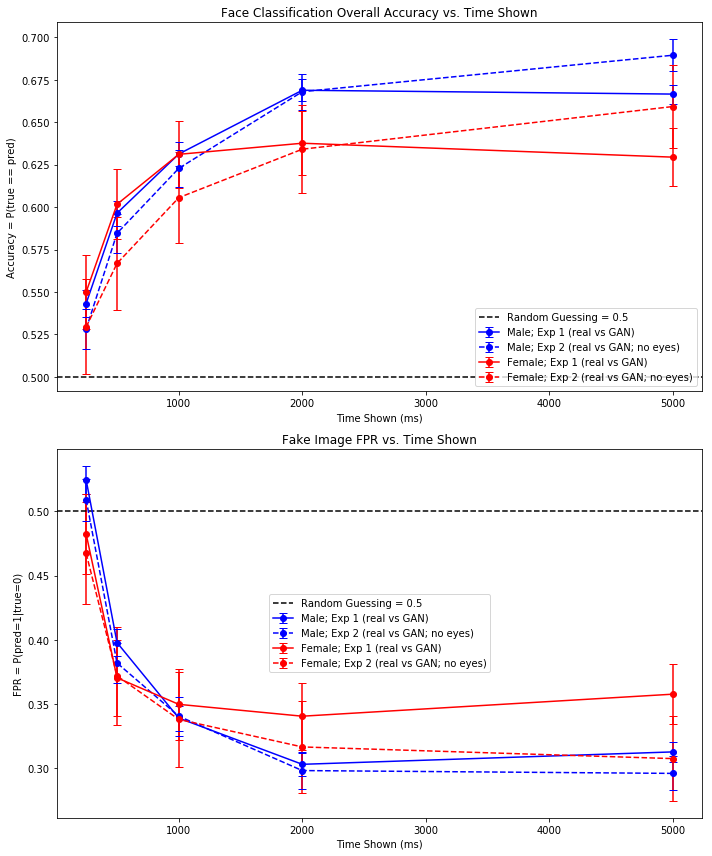

In [331]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)
ax1.set_title("Face Classification Overall Accuracy vs. Time Shown")
ax1.set_xlabel("Time Shown (ms)")
ax1.set_ylabel("Accuracy = P(true == pred)")

ax2 = fig.add_subplot(212)
ax2.set_title("Fake Image FPR vs. Time Shown")
ax2.set_xlabel("Time Shown (ms)")
ax2.set_ylabel("FPR = P(pred=1|true=0)")

gender_id_map = {
    ('male', 1):("Male; Exp 1 (real vs GAN)", "b", "-"), 
    ('male', 2):("Male; Exp 2 (real vs GAN; no eyes)", "b", "--"),
    ('female', 1):("Female; Exp 1 (real vs GAN)", "r", "-"), 
    ('female', 2):("Female; Exp 2 (real vs GAN; no eyes)", "r", "--")
}

for (gender, expt_id), (label, color, linestyle)  in gender_id_map.items():
    exp_data = indiv_gender_results[(indiv_gender_results.gender == gender) & (indiv_gender_results.expt_id == expt_id)]
    ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)


ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")

ax1.legend(loc=0)
ax2.legend(loc=0)

plt.tight_layout()
plt.show()

In [332]:
print ("Exp 1, # datapoints: %d" % df[df.expt_id==1].id.count())
print ("Exp 2, # datapoints: %d" % df[df.expt_id==2].id.count())
print ("---------------------------------------------")
print(indiv_df.groupby(["expt_id", "duration"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))
print(indiv_df[indiv_df.gender != 'other'].groupby(["expt_id", "duration", "gender"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))

Exp 1, # datapoints: 110508
Exp 2, # datapoints: 45744
---------------------------------------------
   expt_id  duration    id
4        1      5000  5079
3        1      2000  3695
2        1      1000  3443
1        1       500  3219
0        1       250  2982
9        2      5000  1789
8        2      2000  1525
7        2      1000  1460
6        2       500  1430
5        2       250  1420
    expt_id  duration  gender    id
8         1      5000  female   519
9         1      5000    male  4529
6         1      2000  female   413
7         1      2000    male  3257
4         1      1000  female   384
5         1      1000    male  3036
2         1       500  female   359
3         1       500    male  2840
0         1       250  female   340
1         1       250    male  2622
18        2      5000  female   246
19        2      5000    male  1530
16        2      2000  female   220
17        2      2000    male  1293
14        2      1000  female   210
15        2      1000    m

In [334]:
img_df = df.groupby('filename').agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
img_df['accuracy'] = img_df.correct / img_df.id



gender_img_df = df.groupby(['filename', 'gender']).agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
gender_img_df['accuracy'] = gender_img_df.correct / gender_img_df.id

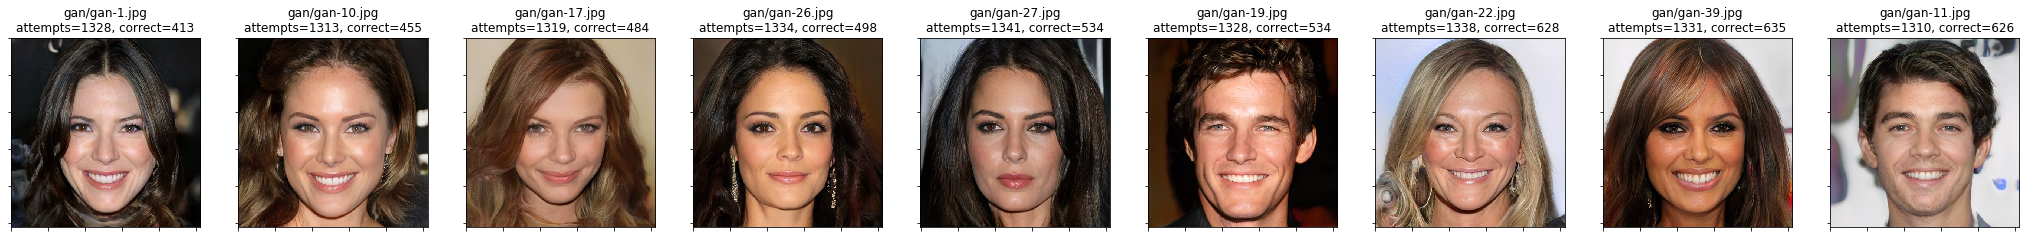

In [336]:
N = 9
expt_id = 1
true = 0
ascending = True

data = img_df[(img_df.true == true) & (img_df.expt_id == expt_id)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

# plt.hist(data.accuracy, bins=10)
# plt.show()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])))
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

fig.savefig('./plots/hard_fake_exp1.svg')
plt.show()

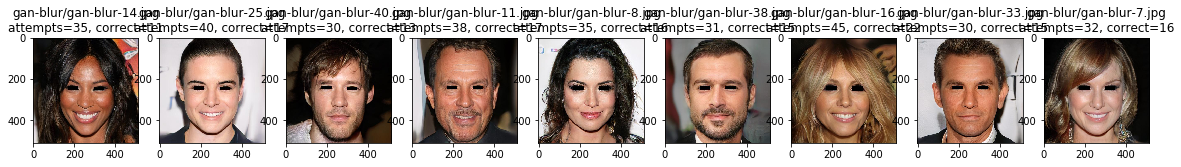

In [268]:
N = 9
true = 0
expt_id = 2
ascending = True
gender = 'female'

data = gender_img_df[(gender_img_df.true == true) & (gender_img_df.expt_id == expt_id) & (gender_img_df.gender == gender)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

fig = plt.figure(figsize=(20,4))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])))
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))

plt.show()